In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from utils import *
from models import *
from optimizers import *
from functions import *

In [2]:
def load_data(path, image_size, split=1):
    data = []
    labels = []
    total = os.listdir(path)
    total_len = len(total)

    for idx, label in enumerate(total):
        path_label = os.path.join(path, label)
        images = os.listdir(path_label)
        images_total = len(images)
        
        labels.extend([idx for _ in range(int(images_total*split))])
        
        for jdx, image in enumerate(images):
            if jdx >= int(images_total*split): 
                continue
            
            path_image = os.path.join(path_label, image)
            
            try:
                img = cv.imread(path_image)
                img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                img_resized = cv.resize(img_gray, (image_size, image_size))
                data.append(img_resized)
            except Exception as e:
                print(f"Error {path_image}: {e}")
                continue
            
            print(f'Images [{jdx+1}/{int(images_total*split)}] of [{idx+1}/{total_len}]', end='\r')

    return data, labels

In [ ]:
path = r'\Medical-AI-with-numpy\datasets\Pulmones'
path_train = path + r'\train'
path_test = path + r'\test'

In [4]:
section = 0.1
data_train, labels_train = load_data(path_train, 112, section)
data_test, labels_test = load_data(path_test, 112, section)

In [5]:
data_train, labels_train = np.array(data_train).astype('float32') / 255.0, np.array(labels_train).astype('float32')
data_test, labels_test = np.array(data_test).astype('float32') / 255.0, np.array(labels_test).astype('float32')

In [6]:
data_train, labels_train = np.expand_dims(data_train, axis=-1), np.expand_dims(labels_train, axis=-1)
data_test, labels_test = np.expand_dims(data_test, axis=-1), np.expand_dims(labels_test, axis=-1)

In [7]:
print(data_train.shape, labels_train.shape)

(521, 112, 112, 1) (521, 1)


In [8]:
print(np.max(data_train), np.min(data_train))

1.0 0.0


In [9]:
data_train, labels_train = shuffle_data(data_train, labels_train)
data_test, labels_test = shuffle_data(data_test, labels_test)

In [10]:
model = SimpleCNN(data_train.shape[1:])
model.compile(
    loss=BCE,
    optimizer=Adam(lr=0.001),
    accuracy=SingleBinaryAccuracy
)

In [11]:
history_loss, history_acc = model.train(data_train, labels_train, epochs=15, batch_size=16, print_every=0.1)

Epoch: [1/15]> Loss: 0.6620, Acc: 0.7460
Epoch: [2/15]> Loss: 0.2795, Acc: 0.8834
Epoch: [3/15]> Loss: 0.2104, Acc: 0.9175
Epoch: [4/15]> Loss: 0.1014, Acc: 0.9621
Epoch: [5/15]> Loss: 0.0368, Acc: 0.9886
Epoch: [6/15]> Loss: 0.0124, Acc: 1.0000
Epoch: [7/15]> Loss: 0.0056, Acc: 1.0000
Epoch: [8/15]> Loss: 0.0051, Acc: 1.0000
Epoch: [9/15]> Loss: 0.0011, Acc: 1.0000
Epoch: [10/15]> Loss: 0.0006, Acc: 1.0000
Epoch: [11/15]> Loss: 0.0004, Acc: 1.0000
Epoch: [12/15]> Loss: 0.0004, Acc: 1.0000
Epoch: [13/15]> Loss: 0.0003, Acc: 1.0000
Epoch: [14/15]> Loss: 0.0003, Acc: 1.0000
Epoch: [15/15]> Loss: 0.0002, Acc: 1.0000


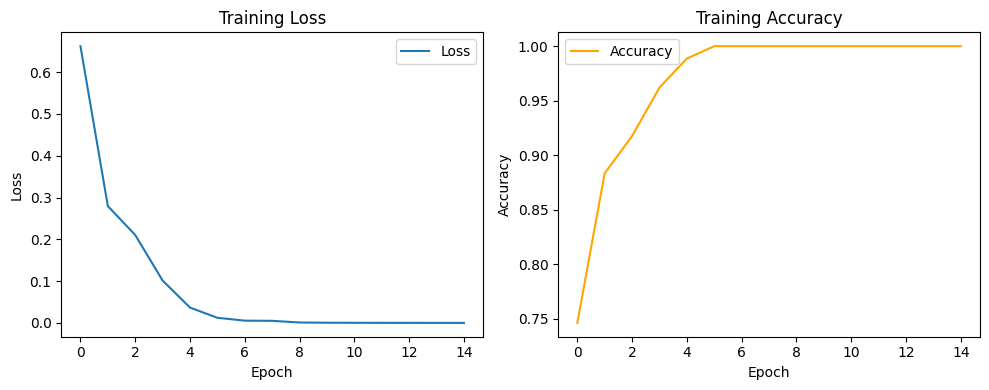

In [12]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_loss, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_acc, label='Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
BinaryAccuracy(labels_test, data_test, model)

(np.float64(0.6774193548387096), np.float64(0.05387026931248047))

In [14]:
def visualize_feature_maps(image, layer_output, layer_name="", n_cols=4, base_size=3):
    if len(image.shape) == 4:
        image = image[0]

    feature_maps = layer_output[0]
    n_channels = feature_maps.shape[-1]
    n_rows = np.ceil(n_channels / n_cols).astype(int)

    fig_height = base_size * (n_rows + 1)
    fig_width = base_size * n_cols
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    gs = gridspec.GridSpec(n_rows + 1, n_cols, figure=fig)

    ax_img = fig.add_subplot(gs[0, :])
    ax_img.imshow(image.squeeze(), cmap='gray')
    ax_img.set_title('Input Image')
    ax_img.axis('off')

    fig.suptitle(f'Feature Maps: {layer_name}', fontsize=14)

    for i in range(n_channels):
        row = (i // n_cols) + 1
        col = i % n_cols

        ax = fig.add_subplot(gs[row, col])
        channel = feature_maps[:, :, i]
        if channel.max() > channel.min():
            channel = (channel - channel.min()) / (channel.max() - channel.min())

        ax.imshow(channel, cmap='viridis', vmin=0, vmax=1)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [42]:
random_idx = np.random.randint(0, data_test.shape[0])
random_image = data_test[random_idx:random_idx+1]
image = model.forward(random_image)

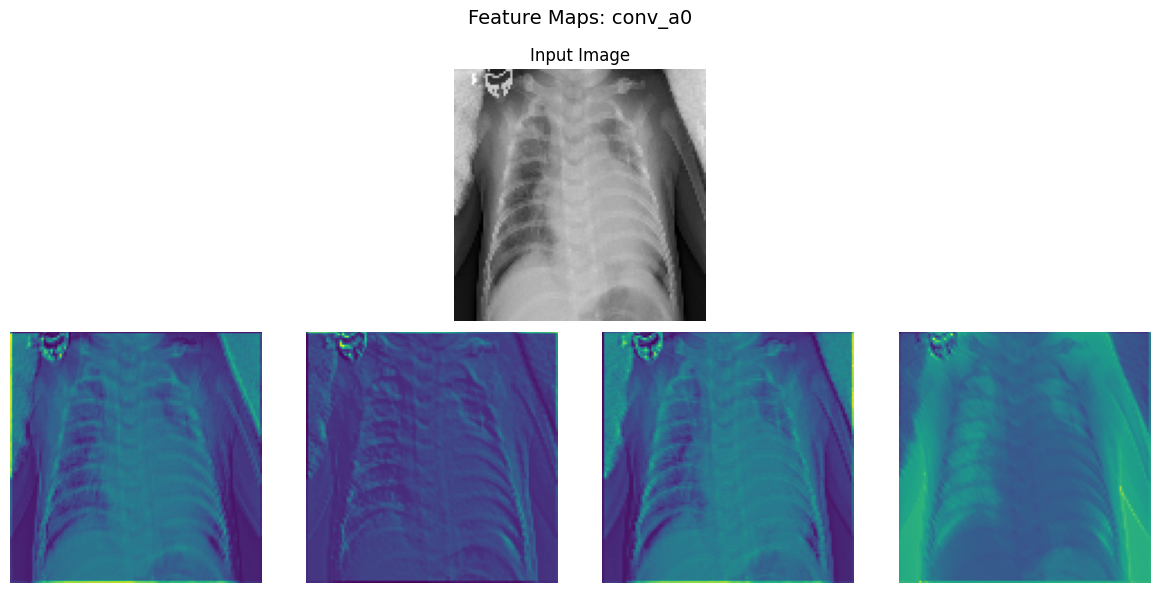

In [43]:
visualize_feature_maps(random_image, model.conv_a0, 'conv_a0', n_cols=4)

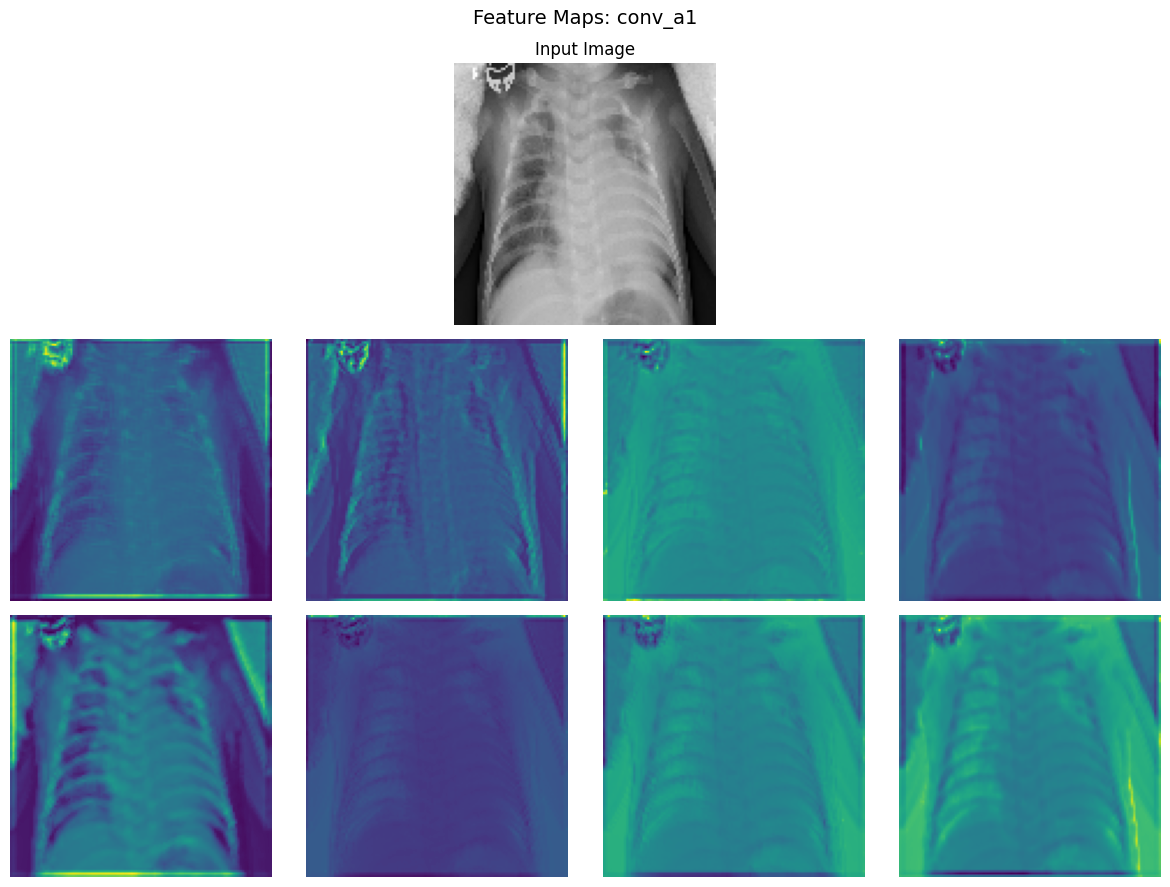

In [44]:
visualize_feature_maps(random_image, model.conv_a1, 'conv_a1', n_cols=4)

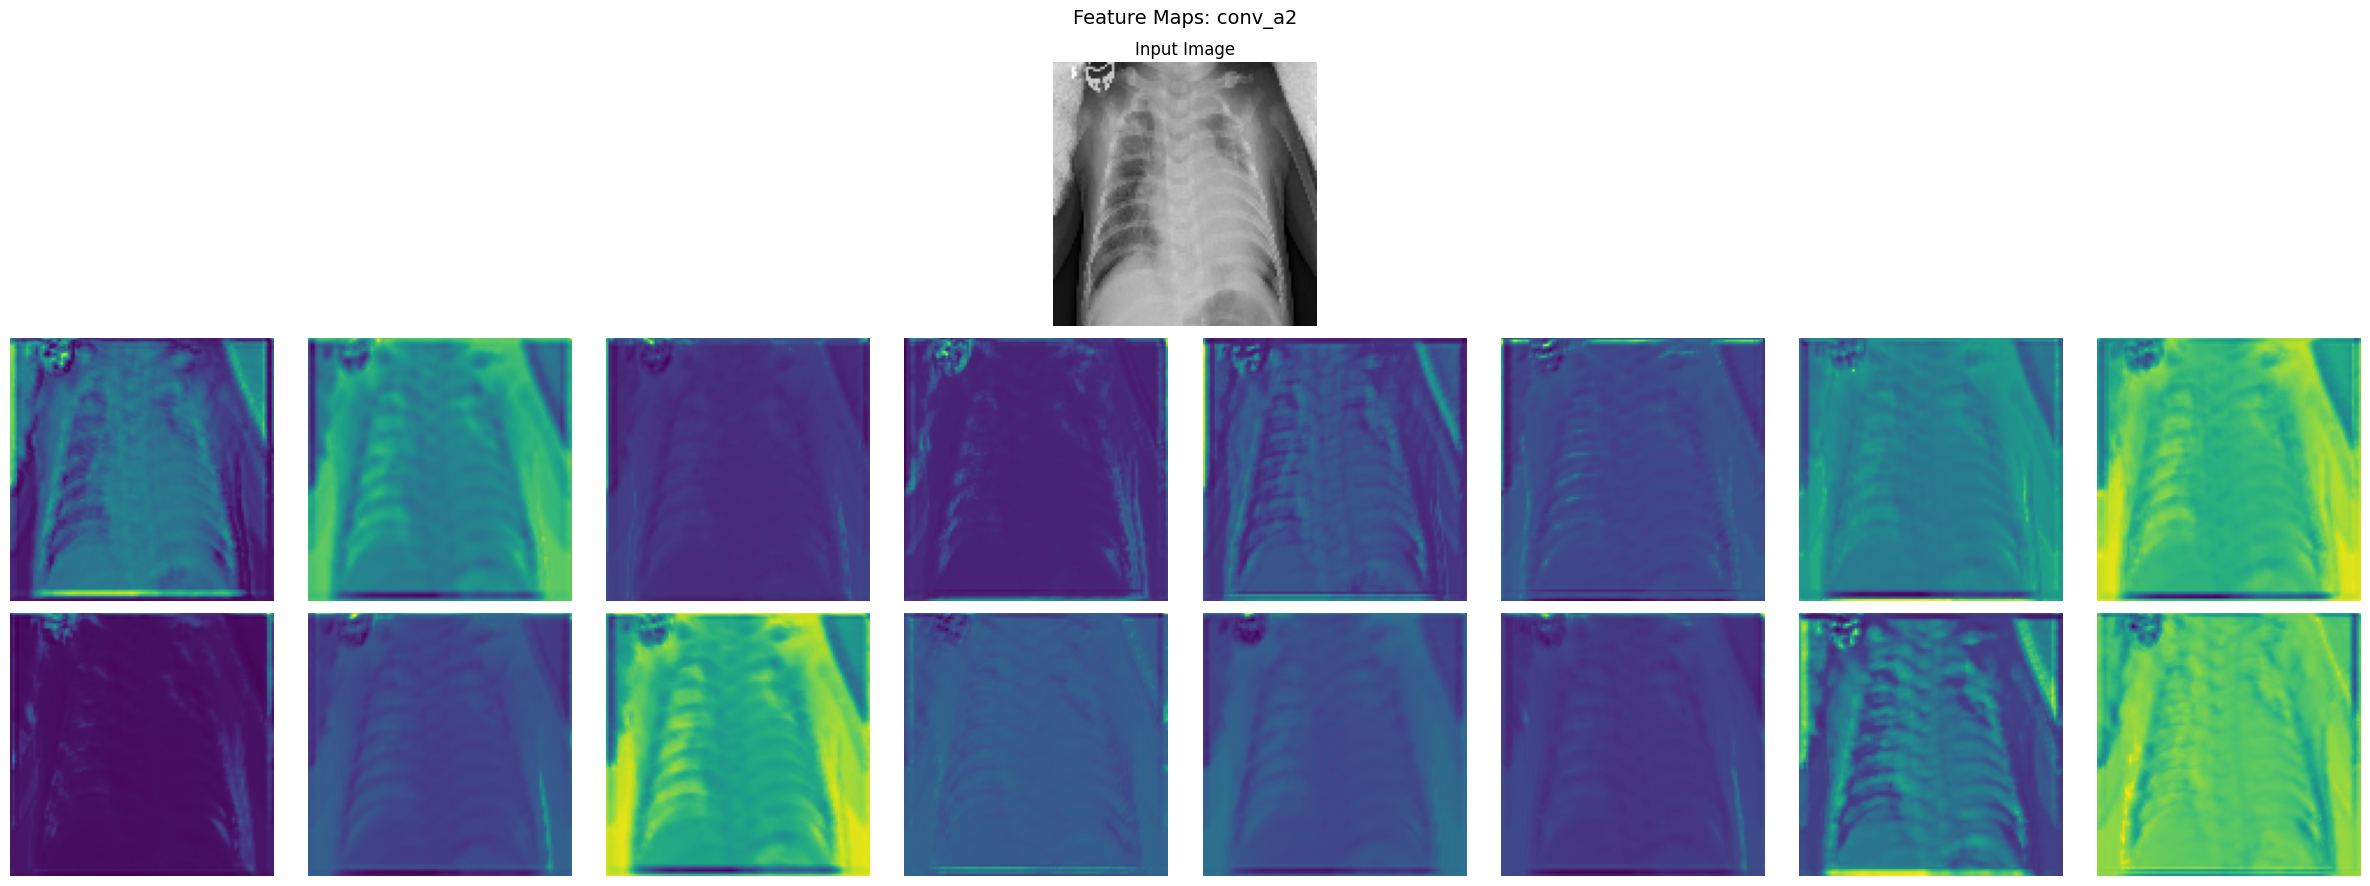

In [45]:
visualize_feature_maps(random_image, model.conv_a2, 'conv_a2', n_cols=8)

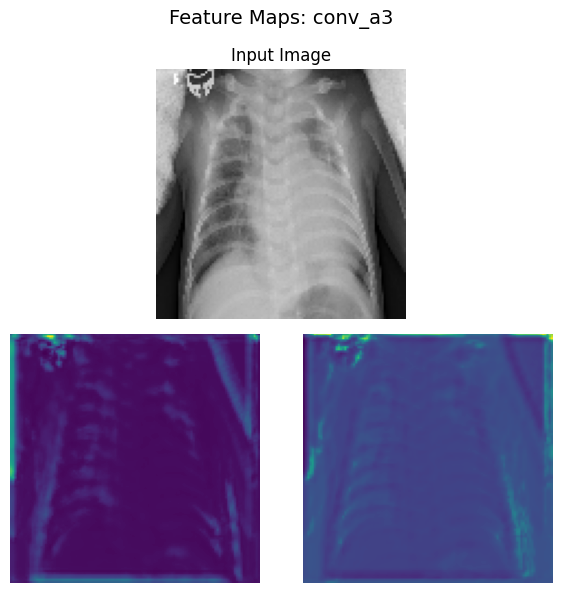

In [46]:
visualize_feature_maps(random_image, model.conv_a3, 'conv_a3', n_cols=2)